In [7]:
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt 
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from time import time
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

def agg_from_date(dates):
    aggs = {}
    aggs['dayofweek'] = pd.Series(dates).dt.dayofweek.astype(float)
    aggs['quarter'] = pd.Series(dates).dt.quarter.astype(float)
    aggs['month'] = pd.Series(dates).dt.month.astype(float)
    aggs['year'] = pd.Series(dates).dt.year.astype(float)
    aggs['dayofyear'] = pd.Series(dates).dt.dayofyear.astype(float)
    aggs['dayofmonth'] = pd.Series(dates).dt.day.astype(float)
    aggs['weekofyear'] = pd.Series(dates).dt.isocalendar().week.astype(float)
    aggs['hour'] = pd.Series(dates).dt.hour.astype(float)
    return(pd.DataFrame(aggs).set_index(dates))
import warnings
warnings.filterwarnings("ignore")

In [177]:
def dataset_get(aggs=True):
    df1 = pd.read_csv('datasets/energy_dataset.csv')
    df1.index = df1.time.apply(lambda x: np.datetime64(x))
    df1.drop(columns = ['time'],inplace=True)

    df2 = pd.read_csv('datasets/weather_features.csv')
    df2.index = df2.dt_iso.apply(lambda x: np.datetime64(x))
    df2.drop(columns = ['dt_iso'],inplace=True)

    df2_agg = df2.groupby(df2.index.date)[['temp','humidity','wind_speed','clouds_all','rain_1h']].mean()

    df1_agg = df1.groupby(df1.index.date)[['generation biomass',     'generation fossil brown coal/lignite',
                                           'generation fossil gas',  'generation fossil hard coal',
                                           'generation fossil oil',  'generation nuclear',
                                           'generation solar',       'total load actual']].mean()
    df =df1_agg.join(df2_agg)
    df.index = pd.DatetimeIndex(df.index)
    if aggs:
        df = df.merge(agg_from_date(df.index),left_index=True,right_index=True)
    df_train = df[df.index <  pd.Timestamp(day=1,month=9,year=2018)]
    df_test  = df[df.index >= pd.Timestamp(day=1,month=9,year=2018)]

    return(df,df_train,df_test)

In [156]:
df,df_train,df_test = dataset_get()
obj = 'total load actual'

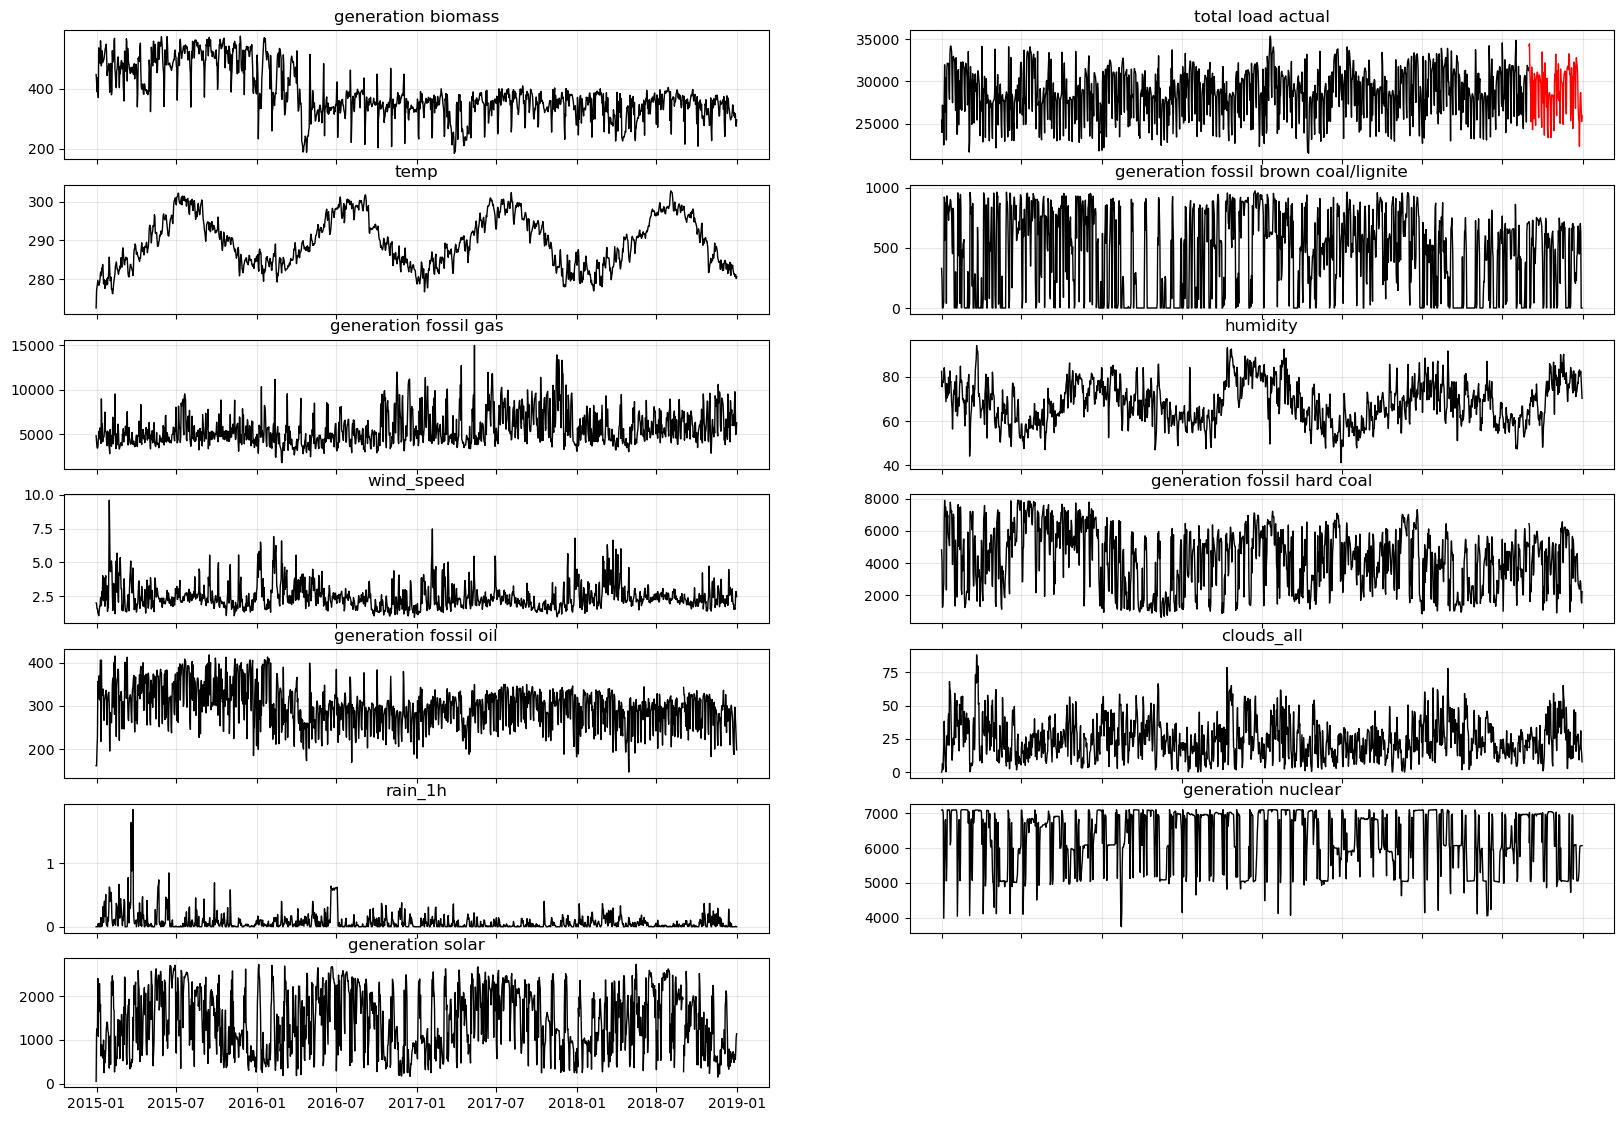

In [157]:
fig,axs = plt.subplots(7,2,figsize=(20,14),dpi=100)
for i,col in enumerate(df.columns[:13]):

    axs[i%7,i%2].plot(df_train.index,df_train[col],color='k',lw=1)
    if col == obj:
        axs[i%7,i%2].plot(df_test.index,df_test[col],color='r',lw=1)
    else:
        axs[i%7,i%2].plot(df_test.index,df_test[col],color='k',lw=1)
    if i%7 != 6:
        axs[i%7,i%2].set_xticklabels([])
    axs[i%7,i%2].set_title(col)
    axs[i%7,i%2].grid(alpha=0.3)
axs[6,1].set_visible(False)

# XGBoost/Linear Model Naive

,Variables,Train time,Prediction time,RMSE
XGBRegressor,21,0.317409,0.002871,1853.116239
LinearRegression,21,0.001734,0.000734,2396.451389
KNeighborsRegressor,21,0.002986,0.002335,2776.106929


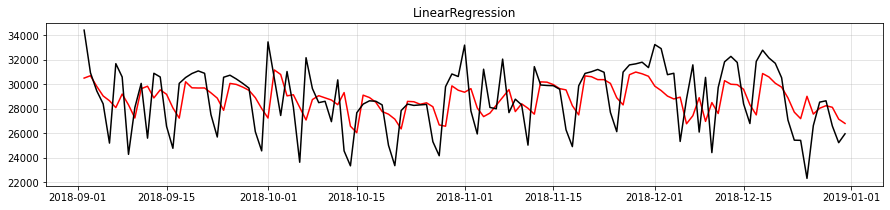

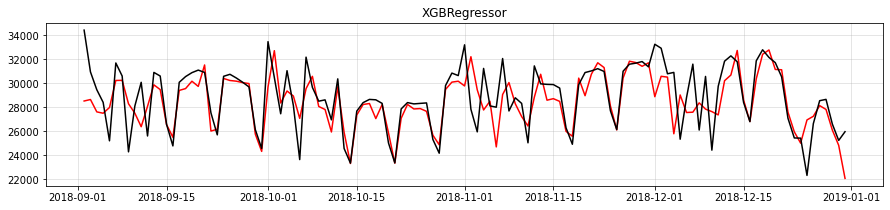

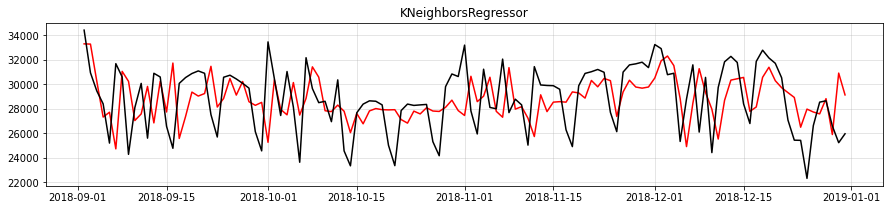

In [202]:
obj = 'total load actual'
results = pd.DataFrame(columns=['Variables','Train time','Prediction time','RMSE'],index=["XGBRegressor",'LinearRegression'])


for model in [LinearRegression(),XGBRegressor(),KNeighborsRegressor()]:
    
    df,df_train,df_test = dataset_get()
    
    X = df_train.loc[:,:]
    Xt = df_test.loc[:,:]
    y = df[obj].shift(-1).loc[df_train.index]
    yt = df_test[obj]

    t1 = time()
    model.fit(X,y)
    t2 = time()
    model_time = t2 - t1

    t1 = time()
    yhat = model.predict(Xt)
    t2 = time()
    predict_time = t2 - t1 

    error = mean_squared_error(yt[1:],yhat[:-1],squared=False)

    plt.figure(figsize=(15,3))
    plt.plot(yt.index[1:],yhat[:-1],color='r',label='prediction')
    plt.plot(yt.index[1:],yt[1:],label='real value',color='k')
    plt.title(f'{type(model).__name__}')
    plt.grid(alpha=0.4)
    
    results.loc[type(model).__name__,'Train time'] = model_time
    results.loc[type(model).__name__,'Prediction time'] = predict_time
    results.loc[type(model).__name__,'RMSE'] = error
    results.loc[type(model).__name__,'Variables'] = int(X.shape[1])
display(results.style.background_gradient(subset=['RMSE'],cmap='RdYlGn_r'))

# XGBoost/Linear Model Naive + lags

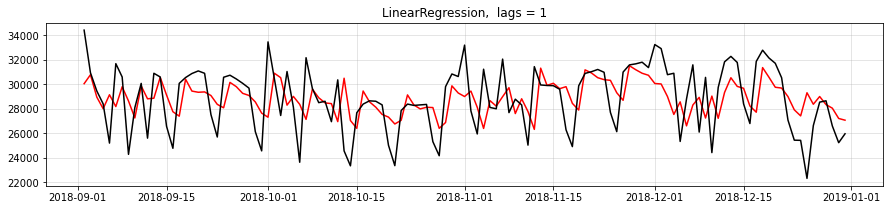

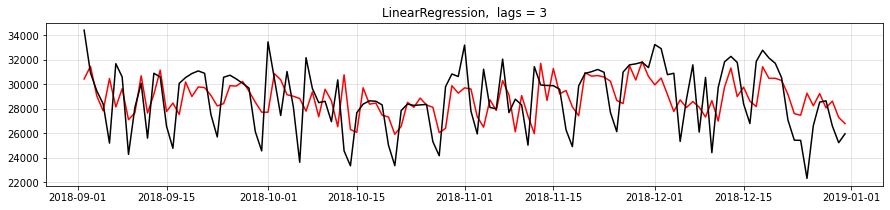

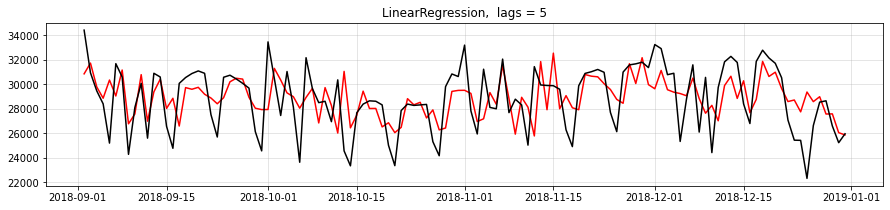

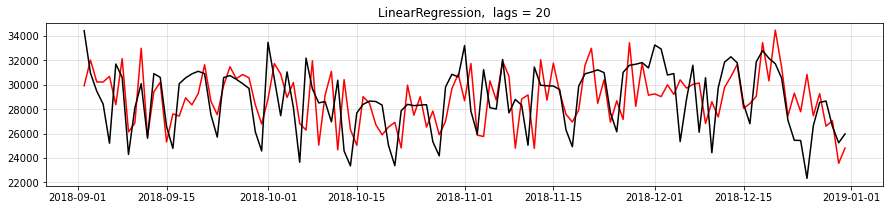

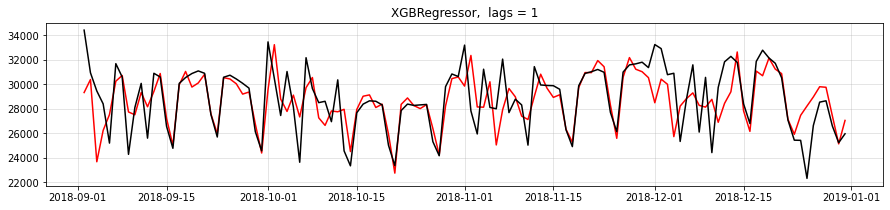

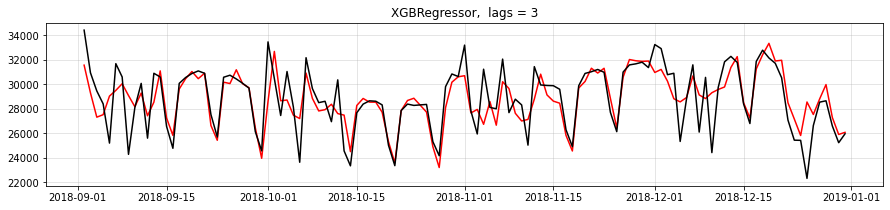

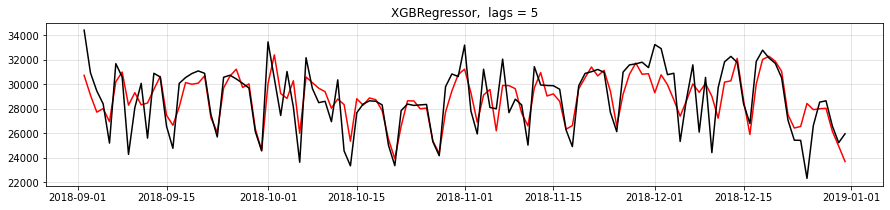

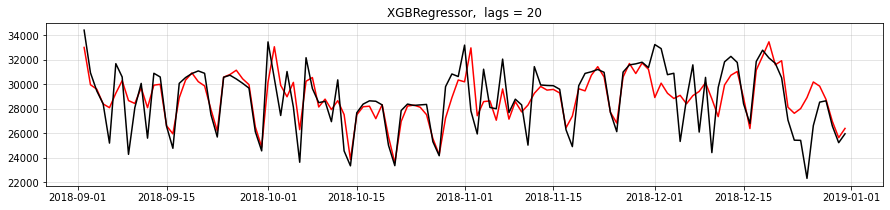

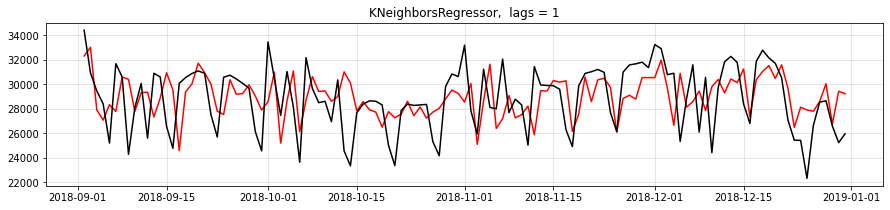

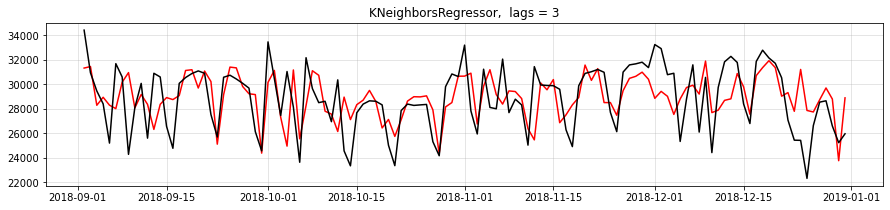

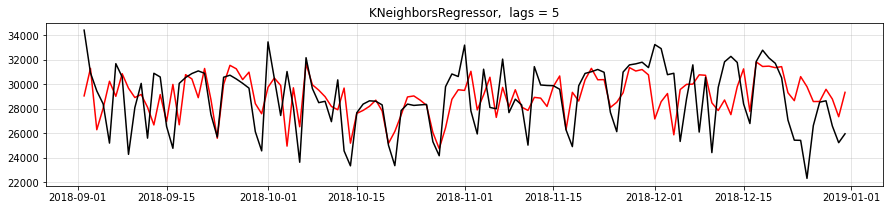

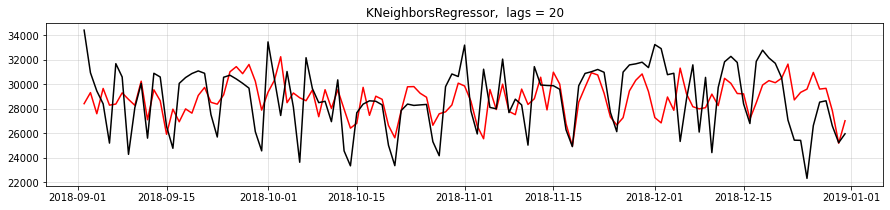

In [200]:
obj = 'total load actual'
iterables = [["XGBRegressor",'LinearRegression'], [1,3,5,20]]
Mindex = pd.MultiIndex.from_product(iterables, names=["Model",'Lags'])
results = pd.DataFrame(columns=Mindex,index=['Variables','Train time','Prediction time','RMSE']).T

for model in [LinearRegression(),XGBRegressor(),KNeighborsRegressor()]:

    df,df_train,df_test = dataset_get()
    
    for lags in [1,3,5,20]:
        
        for col in df.columns[:10]:
            for j in range(1,lags+1):
                df.loc[:,f'{col}_lag_{j}'] = df.loc[:,col].shift(j).copy()
            df = df.iloc[lags-1:,:]

        df_train = df[df.index <  pd.Timestamp(day=1,month=9,year=2018)]
        df_test  = df[df.index >= pd.Timestamp(day=1,month=9,year=2018)]


        X = df_train.iloc[lags:,:]
        Xt = df_test.iloc[:,:]
        y = df[obj].shift(-1).loc[df_train.index].iloc[lags:]
        yt = df_test[obj]

        t1 = time()
        model.fit(X,y)
        t2 = time()
        model_time = t2 - t1

        t1 = time()
        yhat = model.predict(Xt)
        t2 = time()
        predict_time = t2 - t1 

        error = mean_squared_error(yt[1:],yhat[:-1],squared=False)
        
        plt.figure(figsize=(15,3))
        plt.plot(yt.index[1:],yhat[:-1],color='r',label='prediction')
        plt.plot(yt.index[1:],yt[1:],label='real value',color='k')
        plt.title(f'{type(model).__name__},  lags = {lags}')
        plt.grid(alpha=0.4)
        
        results.loc[(type(model).__name__,lags),'Train time'] = model_time
        results.loc[(type(model).__name__,lags),'Prediction time'] = predict_time
        results.loc[(type(model).__name__,lags),'RMSE'] = error
        results.loc[(type(model).__name__,lags),'Variables'] = int(X.shape[1])
display(results.style.background_gradient(subset=['RMSE'],cmap='RdYlGn_r'))

# Prophet

In [186]:
df,df_train,df_test = dataset_get(aggs=False)
df['y'] = df[obj]; df_train['y'] = df_train[obj]; df_test['y'] = df_test[obj]
df.drop(columns=[obj],inplace=True); df_train.drop(columns=[obj],inplace=True);df_test.drop(columns=[obj],inplace=True)
df['ds'] = df.index; df_train['ds'] = df_train.index; df_test['ds'] = df_test.index
results = pd.DataFrame(columns=['Variables','Train time','Prediction time','RMSE'],index=["Prophet univariate",'Prophet Multivariate'])

In [193]:
for col in df_train.columns:
    if col != 'y' and col != 'ds':
        print(col)

generation biomass
generation fossil brown coal/lignite
generation fossil gas
generation fossil hard coal
generation fossil oil
generation nuclear
generation solar
temp
humidity
wind_speed
clouds_all
rain_1h


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.24768
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       3049.67    0.00112783       269.123   1.325e-05       0.001      111  LS failed, Hessian reset 
      99       3050.48    0.00100866       77.0455           1           1      152   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       3051.28   0.000677669       251.973    6.79e-06       0.001      231  LS failed, Hessian reset 
     185       3051.43   3.34211e-05       66.2562    4.81e-07       0.001      334  LS failed, Hessian reset 
     199       3051.43   3.97592e-07       57.2285      0.2975      0.2975      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       3051.44   1.46137e-05       67.9859   1.937e-07       0.001      418  LS failed, Hessian reset 
     255       3051.44   2.37036e-07       64.2506   3.588e-09   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.24768
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3499.82    0.00457309       275.083           1           1      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3504.46   0.000828466       164.856     0.04367           1      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       3504.95   0.000130318       121.684   1.846e-06       0.001      318  LS failed, Hessian reset 
     299       3505.14    0.00122681        111.57       0.845       0.845      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     367       3505.72    0.00014162       104.075   5.177e-07       0.001      488  LS failed, Hessian reset 
     399        3505.9   9.56069e-05       55.8591        0.31           1      522   
    Iter      log pro

,Variables,Train time,Prediction time,RMSE
Prophet univariate,14,0.2349,0.877963,2245.397581
Prophet Multivariate,14,0.518099,0.894485,1726.327913


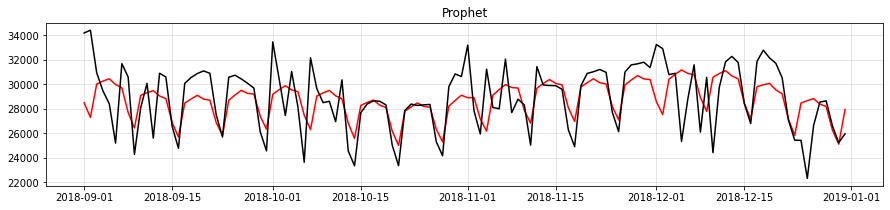

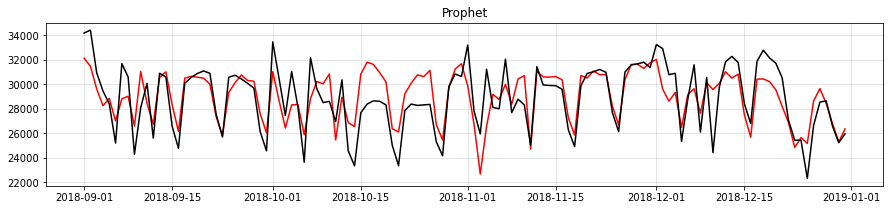

In [195]:
for prophet_k in ["Prophet univariate",'Prophet Multivariate']:
    t1 = time()
    m = Prophet()
    if prophet_k == 'Prophet Multivariate':
        for col in df_train.columns:
            if col != 'y' and col != 'ds':
                m.add_regressor(col)
    m.fit(df_train,verbose=False)
    t2 = time()
    model_time = t2 - t1

    t1 = time()
    predict = m.predict(df_test.drop(columns=['y']))
    t2 = time()
    predict_time = t2 - t1

    predict.index =predict.ds
    yhat = predict['yhat']
    yt = df_test['y']

    plt.figure(figsize=(15,3))
    plt.plot(yhat,color='r',label='prediction')
    plt.plot(yt,label='real value',color='k')
    plt.title(f'Prophet')
    plt.grid(alpha=0.4)

    error = mean_squared_error(yhat, yt,squared=False)

    results.loc[prophet_k,'Train time'] = model_time
    results.loc[prophet_k,'Prediction time'] = predict_time
    results.loc[prophet_k,'RMSE'] = error
    results.loc[prophet_k,'Variables'] = int(df_train.shape[1])

display(results)

# Exogenous ARIMA

In [196]:
df,df_train,df_test = dataset_get(aggs=False)

results = pd.DataFrame(columns=['Variables','Train time','Prediction time','RMSE'],index=["ARIMA univariate",'ARIMA Multivariate'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=24759.754, Time=1.00 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=25028.170, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=24815.963, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=24776.421, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=31323.929, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=24776.131, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=24799.621, Time=0.47 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=24761.423, Time=0.99 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=24730.465, Time=1.53 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=24762.729, Time=0.29 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=24740.093, Time=1.72 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=24753.245, Time=1.89 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=24767.217, Time=0.73 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=24712.168, Time=2.04 sec
 ARIMA(4,0,4)(0,0,0

,Variables,Train time,Prediction time,RMSE
ARIMA univariate,13,27.949536,0.005419,2534.445242
ARIMA Multivariate,13,55.587697,0.009441,1986.156654


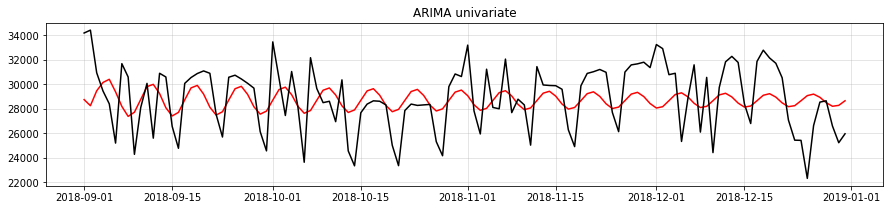

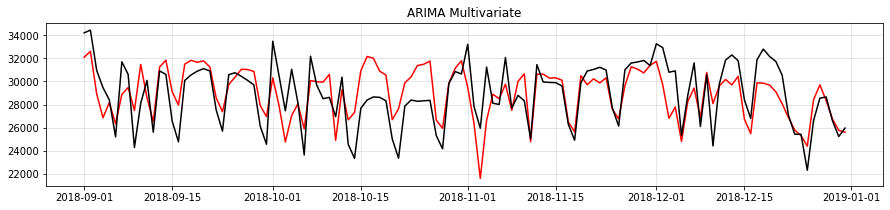

In [198]:
for ARIMA_kind in ["ARIMA univariate",'ARIMA Multivariate']:
    if ARIMA_kind == "ARIMA univariate":
        exogenous = None
    else:
        exogenous = df_train.drop(columns = [obj])
    t1 = time()
    model = pm.auto_arima(df_train[obj],
                          exogenous=exogenous,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=5, max_q=5, # maximum p and q
                          m=1,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=True,   # No Seasonality
                          start_P=1, 
                          D=None, 
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
    t2 = time()
    model_time = t2 - t1 


    t1 = time()
    yhat = model.predict(len(df_test),df_test.drop(columns=[obj]))
    t2 = time()
    predict_time = t2 - t1

    plt.figure(figsize=(15,3))
    plt.plot(df_test.index,yhat,color='r',label='prediction')
    plt.plot(df_test[obj],label='real value',color='k')
    plt.title(f'{ARIMA_kind}')
    plt.grid(alpha=0.4)

    error = mean_squared_error(yhat,df_test[obj],squared=False)

    results.loc[ARIMA_kind,'Variables'] = df_train.shape[1]
    results.loc[ARIMA_kind,'Train time'] = model_time
    results.loc[ARIMA_kind,'Prediction time'] = predict_time
    results.loc[ARIMA_kind,'RMSE'] = error
display(results)